In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join

In [2]:
import matplotlib.pyplot as plt

In [3]:
from itertools import combinations
from collections import Counter

In [4]:
### merging 12 months of sales data into a single csv file

In [5]:
onlyfiles = [f for f in listdir('./Sales_Data/')]

all_data = pd.DataFrame()

for file in onlyfiles:
    df = pd.read_csv('./Sales_data/'+file)
    all_data = pd.concat([all_data, df])
all_data.to_csv('./AllMonthsData.csv', index=False)

In [6]:
### Read in updated data

In [7]:
allData = pd.read_csv('./AllMonthsData.csv')

In [8]:
### Cleanup the data
### rows with NaN values and Empty Data

In [9]:
allData = allData.dropna(axis=0, how='all')

In [10]:
allData = allData[allData['Order Date'].str[0:2] != 'Or']

In [11]:
### Convert columns to correct data type Qty, Price, OrderDate

In [12]:
allData['Quantity Ordered'] = pd.to_numeric(allData['Quantity Ordered'])
allData['Price Each'] = pd.to_numeric(allData['Price Each'])
allData['Order Date'] = pd.to_datetime(allData['Order Date'])


In [13]:
### Augment data with some additional columns
## Add Month column

In [14]:
allData['Month'] = allData['Order Date'].dt.month

allData['Hour'] = allData['Order Date'].dt.hour
allData['Minute'] = allData['Order Date'].dt.minute
allData['Count'] = 1
allData.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Hour,Minute,Count
0,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",12,0,1,1
1,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",12,7,3,1
2,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",12,18,21,1
3,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",12,15,13,1
4,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",12,12,38,1


In [15]:
### Add a salestotal column for qty * price in the dataframe

In [16]:
allData['SalesTotal'] = allData['Quantity Ordered'] * allData['Price Each']

In [17]:
#### Separate out the city (ST)

In [18]:
#### use the dot apply method from pandas with a format string

In [19]:
def get_city(address):
    return address.split(',')[1]

def get_state(address):
    return address.split(',')[2].split(' ')[1]

allData['City'] = allData['Purchase Address'].apply(lambda x: f"{get_city(x)} ({get_state(x)})")


In [20]:
results = allData.groupby('Month').sum()

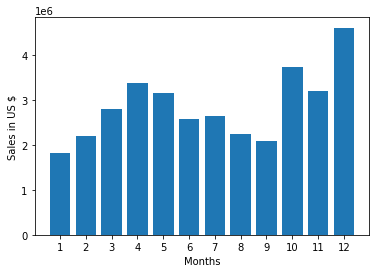

In [21]:
months = range(1,13)
plt.bar(months, results['SalesTotal'])
plt.xticks(months)
plt.ylabel('Sales in US $')
plt.xlabel('Months')
plt.show()

In [22]:
#### What US city had the highest number of sales
results = allData.groupby('City').sum()

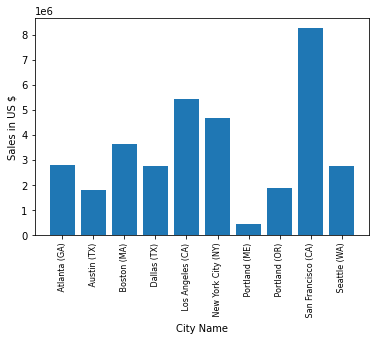

In [23]:
## This groups unique citys into a list of City names in same order as results table
cities = [city for city, df in allData.groupby('City')]

plt.bar(cities, results['SalesTotal'])
plt.xticks(cities, rotation='vertical', size=8)
plt.ylabel('Sales in US $')
plt.xlabel('City Name')
plt.show()

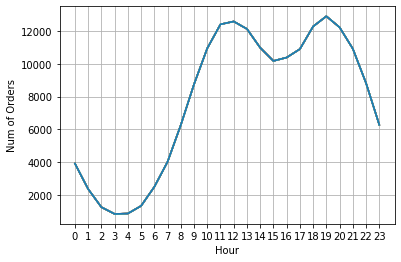

In [24]:
hours = [hour for hour, df in allData.groupby('Hour')]

plt.plot(hours, allData.groupby(['Hour']).count())
plt.xticks(hours)
plt.xlabel('Hour')
plt.ylabel('Num of Orders')
plt.grid()

plt.show()

In [25]:
### Let's get a new dataframe with JUST the rows that are duplicate by order ID
## duplicated(keep=False) keeps ALL duplcated rows, not just the first or last
df = allData[allData['Order ID'].duplicated(keep=False)]
df = df.copy()   ## This makes df an actual memory copy and not a view anymore
df.drop(['Hour', 'Minute', 'City'], axis=1, inplace=True)
df['Grouped'] = df.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))
## Now drop the duplicates by order id
df = df[['Order ID', 'Grouped', 'Count']].drop_duplicates()



In [26]:
count = Counter()
for row in df['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))
    
count.most_common(10)
for key, value in count.most_common(15):
    print(key, value)

('iPhone', 'Lightning Charging Cable') 1005
('Google Phone', 'USB-C Charging Cable') 987
('iPhone', 'Wired Headphones') 447
('Google Phone', 'Wired Headphones') 414
('Vareebadd Phone', 'USB-C Charging Cable') 361
('iPhone', 'Apple Airpods Headphones') 360
('Google Phone', 'Bose SoundSport Headphones') 220
('USB-C Charging Cable', 'Wired Headphones') 160
('Vareebadd Phone', 'Wired Headphones') 143
('Lightning Charging Cable', 'Wired Headphones') 92
('Lightning Charging Cable', 'Apple Airpods Headphones') 81
('Vareebadd Phone', 'Bose SoundSport Headphones') 80
('USB-C Charging Cable', 'Bose SoundSport Headphones') 77
('Apple Airpods Headphones', 'Wired Headphones') 69
('Lightning Charging Cable', 'USB-C Charging Cable') 58


In [27]:
df = allData.groupby('Product')

quantity_ordered = df.sum()['Quantity Ordered']
products = [product for product, dataframe in df]

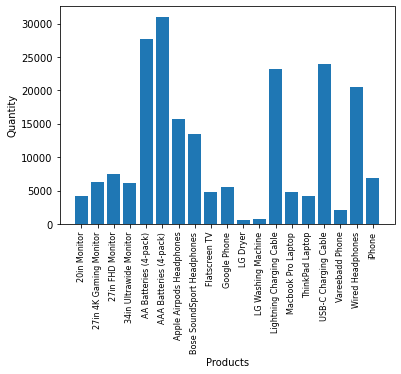

In [28]:
plt.bar(products, quantity_ordered)
plt.xticks(products, rotation='vertical', size=8)
plt.ylabel('Quantity')
plt.xlabel('Products')
plt.show()

/var/folders/jq/njhl8w417hq8zf2m2t2njkwm0000gn/T/ipykernel_1431/2575234625.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(products, rotation='vertical', size=8)


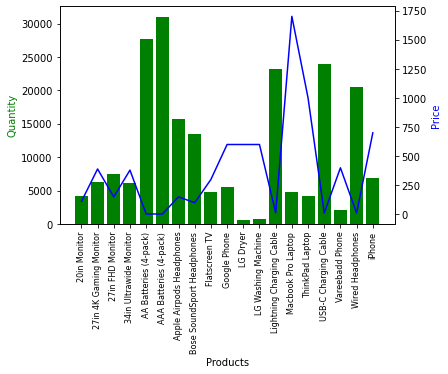

In [29]:
prices = allData.groupby('Product').mean()['Price Each']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(products, quantity_ordered, color='g')
ax2.plot(products, prices, 'b-')

ax1.set_xlabel('Products')
ax1.set_ylabel('Quantity', color='g')
ax2.set_ylabel('Price', color='b')
ax1.set_xticklabels(products, rotation='vertical', size=8)

plt.show()